# Digit recogizer
> ref: https://www.kaggle.com/danielhkl/simple-3-layer-l2-neural-networks-97-9

## 1. Import relative module

In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
# define some constant
TRAIN_DATA_PATH = "./input/train.csv"
TEST_DATA_PATH = "./input/test.csv"

## 2. Define function

In [5]:
# Convert label to one-hot matrix
# one-hot: make label into 0 or 1 matrix
# if axis = 0 : output shape = depth x indices.size 
# if axis = -1 : output shape = indices.size x depth
# if axis = 1 : output shape = indices.n x depth x indices.m
# 
def convert_to_one_hot(label_set, label_len):
    one_hot_matrix = tf.one_hot(indices=label_set, depth=label_len, axis=0)
    sess = tf.Session()
    one_hot_label = sess.run(one_hot_matrix)
    sess.close()
    # one_hot_label.shape = (10, 1, 42000)
    return np.squeeze(one_hot_label)


# Deal with train set in "train.csv"
def load_data(train_data_path, test_data_path):
    # Get train data in file and convert it from Dataframe to Numpy.Array、
    # reshape 由于直接[:, 0]获取的是一个一维（R,)的数组，不是一个（1，R)的矩阵
    train_data = pd.read_csv(train_data_path).as_matrix() 
    train_labels = train_data[:, 0].reshape(1, train_data.shape[0])
    train_labels = convert_to_one_hot(train_labels, int(np.max(train_labels)+1)) # ? np.squeeze()
    train_images = np.divide(train_data[:, 1:], 255).T # 归一化到（0，1）
    
    test_images = np.divide(pd.read_csv(test_data_path).as_matrix(), 255).T
    
    # 将训练集分为两部分 0:4199, 4200:28000, 1:9
    # 其中validation_的数据用于L2 regularization(权重衰减）防止过拟合
    validation_train_images = train_images[:, 1:4200]
    validation_train_labels = train_labels[:, 1:4200]
    train_images = train_images[:, 4200:]
    train_labels = train_labels[:, 4200:]
    
    return train_labels, train_images, validation_train_labels, validation_train_images, test_images

    
# ReLU
# Forward propagation
# 构建前驱网络图
def forward_propagation(X, W1, b1, W2, b2, W3, b3):
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    # 为什么没有最后的tf.nn.relu? 
    return Z3



# Compute L2 regularization cost
# ？不是很懂这里
# Z is arribute of train data.
# Y is label of train data.

def compute_cost(Z, Y, W1, W2, W3, batchsize):
    logits = tf.transpose(Z)  # 转置. Shape = (batchsize, n_out).
    labels = tf.transpose(Y)  # 9 labels to n_out. Shape = (batchsize, n_out).
    unreg_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    L2_reg = tf.multiply(L2_lambda / batchsize, \
                         tf.add(tf.add(tf.nn.l2_loss(W1), tf.nn.l2_loss(W2)), tf.nn.l2_loss(W3)))
    cost = tf.add(unreg_cost, L2_reg)
    return cost



# Initialize all parameters
# n_in: Amount of input layers neurons.
# n_1: Amount of first layers neurons.
# n_2: Amount of second layers neurons.
# n_out: Amount of output layers neurons.
def initialize_parameters(n_in, n_1, n_2, n_out):
    # Take (a, b) as index of a tree, a mean the a root, and the b mean the b child node of a root.
    W1 = tf.get_variable('W1', (n_1, n_in), initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable('b1', (n_1, 1), initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2', (n_2, n_1), initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable('b2', (n_2, 1), initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3', (n_out, n_2), initializer=tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable('b3', (n_out, 1), initializer=tf.zeros_initializer())
    return W1, b1, W2, b2, W3, b3




## 3. Initial graph

In [7]:
# Load data.
train_labels, train_images, \
validation_train_labels, validation_train_images, \
test_images  = load_data(TRAIN_DATA_PATH, TEST_DATA_PATH)

# Parameter and properties setting
learning_rate = 0.001
L2_lambda = 0.05
epoch = 60   # ?
batchsize = 378    # ？
n_in = train_images.shape[0]  # Amount of input layer neurons. (number of pixels in a image) 
n_1 = 300  # Amount of first hiden layers neurons.
n_2 = 120  # Amount of second hiden layers neurons.
n_out = train_labels.shape[0]  # Amount of output layer neurons. 
m = train_images.shape[1]  # Size of samples for training.
m_test = test_images.shape[1]  # Size of samples in test. (m_test == m ?)
total_batches = np.ceil(m / batchsize).astype(np.int32)  

# Setting placeholders.
X = tf.placeholder(tf.float32, (n_in, None), name='X')
Y = tf.placeholder(tf.float32, (n_out, None), name='Y')

# Weights and bias initialization.
W1, b1, W2, b2, W3, b3 = initialize_parameters(n_in, n_1, n_2, n_out)

# Feed forward. z3 is the output of the output layer.
Z3 = forward_propagation(X, W1, b1, W2, b2, W3, b3)

# Define the cost.
cost = compute_cost(Z3, Y, W1, W2, W3, batchsize)

# Define the optimization method. ?
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

# Define the accuracy. ?
correct_pred = tf.equal(tf.argmax(Z3), tf.argmax(Y))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



#Define the initializer
init = tf.global_variables_initializer()


## 4. Run sess

In [8]:

#Model
costs = []
costs_val = []
accuracies = []
accuracies_val = []
sess = tf.Session()
sess.run(init)
for i in range(epoch):
    epoch_cost = 0.
    for j in range(total_batches):
        index_front = j * batchsize
        index_end = (j + 1) * batchsize if (j + 1) * batchsize < m else m
        X_batch = train_images[:, index_front:index_end]
        Y_batch = train_labels[:, index_front:index_end]
        _, batch_cost = sess.run([optimizer, cost], feed_dict={X:X_batch, Y:Y_batch})
        epoch_cost += batch_cost / total_batches
    epoch_cost_val = sess.run(cost, feed_dict={X:validation_train_images, Y:validation_train_labels})
    epoch_acc = sess.run(accuracy, feed_dict={X:train_images, Y:train_labels})
    epoch_acc_val = sess.run(accuracy, feed_dict={X:validation_train_images, Y:validation_train_labels})
    print('Epoch ' + str(i + 1) + \
          ' Training Cost/Validation Cost/Training Accuracy/Validation Accuracy: '\
          + str(epoch_cost) + '/' + str(epoch_cost_val) + '/' + str(epoch_acc) + '/' + str(epoch_acc_val))
    costs.append(epoch_cost)
    costs_val.append(epoch_cost_val)
    accuracies.append(epoch_acc)
    accuracies_val.append(epoch_acc_val)

Epoch 1 Training Cost/Validation Cost/Training Accuracy/Validation Accuracy: 0.508782161474/0.260078/0.939074/0.935461
Epoch 2 Training Cost/Validation Cost/Training Accuracy/Validation Accuracy: 0.215332303643/0.191819/0.961852/0.954513
Epoch 3 Training Cost/Validation Cost/Training Accuracy/Validation Accuracy: 0.160176983178/0.159381/0.97336/0.962372
Epoch 4 Training Cost/Validation Cost/Training Accuracy/Validation Accuracy: 0.129151649252/0.142154/0.980265/0.966182
Epoch 5 Training Cost/Validation Cost/Training Accuracy/Validation Accuracy: 0.110397689044/0.137744/0.98254/0.969278
Epoch 6 Training Cost/Validation Cost/Training Accuracy/Validation Accuracy: 0.0974728392065/0.136212/0.984339/0.96904
Epoch 7 Training Cost/Validation Cost/Training Accuracy/Validation Accuracy: 0.0875170238316/0.131886/0.98664/0.972851
Epoch 8 Training Cost/Validation Cost/Training Accuracy/Validation Accuracy: 0.0791038286313/0.128745/0.989735/0.973803
Epoch 9 Training Cost/Validation Cost/Training Ac

## 5. Figure

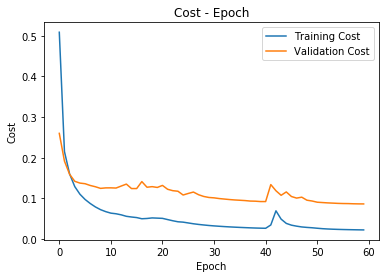

In [9]:
#Ploting the cost
plt.plot(np.squeeze(costs), label='Training Cost')
plt.plot(np.squeeze(costs_val), label='Validation Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.title('Cost - Epoch')
plt.legend(loc='best')
plt.show()

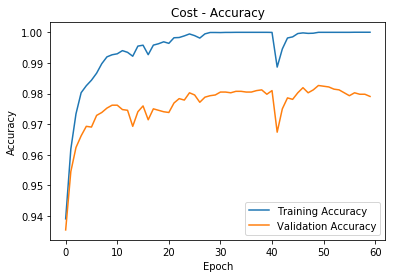

In [10]:
#Ploting the accuracy
plt.plot(np.squeeze(accuracies), label='Training Accuracy')
plt.plot(np.squeeze(accuracies_val), label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Cost - Accuracy')
plt.legend(loc='best')
plt.show()

## 6. Run test and save output file

In [11]:
sess = tf.Session()
#Run the test data and output csv
Z3_test = forward_propagation(X, W1, b1, W2, b2, W3, b3)
A3_test = tf.nn.softmax(Z3_test, dim=0)
predict = np.argmax(sess.run(A3_test, feed_dict={X:test_images}), axis=0)
predict = predict.reshape(predict.shape[0], 1)
image_id = np.arange(1, len(predict) + 1, 1)
image_id = image_id.reshape(len(predict), 1)
np.savetxt('3-layer_L2_NN.csv', np.c_[image_id, predict], delimiter=',', header='ImageId,Label', comments='', fmt='%d')

FailedPreconditionError: Attempting to use uninitialized value b3
	 [[Node: b3/read = Identity[T=DT_FLOAT, _class=["loc:@b3"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](b3)]]

Caused by op 'b3/read', defined at:
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-6ffc3ee6d542>", line 22, in <module>
    W1, b1, W2, b2, W3, b3 = initialize_parameters(n_in, n_1, n_2, n_out)
  File "<ipython-input-5-afc9c79aa29e>", line 76, in initialize_parameters
    b3 = tf.get_variable('b3', (n_out, 1), initializer=tf.zeros_initializer())
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1203, in get_variable
    constraint=constraint)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1092, in get_variable
    constraint=constraint)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 425, in get_variable
    constraint=constraint)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 394, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 805, in _get_single_variable
    constraint=constraint)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 213, in __init__
    constraint=constraint)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2071, in identity
    "Identity", input=input, name=name)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value b3
	 [[Node: b3/read = Identity[T=DT_FLOAT, _class=["loc:@b3"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](b3)]]


## 7. Close sess

In [ ]:
sess.close()